# Lorenz-63 に対する RNN のパラメータ推定を Kalman Filter で行う３

0115の発表用


In [1]:
import numpy as np
import matplotlib.pyplot as plt
lfontsize = 14

import seaborn as sns

print(f"numpy version: {np.__version__}")

numpy version: 1.23.2


In [2]:
def L63_explicit(X: np.ndarray, t: float) -> np.ndarray:
    """
    L63 model with explicit time stepping
    input: 
        t = time
        X = [x, y, z, sigma, rho, beta]
    output: dX/dt
    """
    x, y, z = X[0:3]
    s, r, b = X[3:6]
    dx = s * (y - x)
    dy = x * (r - z) - y
    dz = x * y - b * z
    ds = 0
    dr = 0
    db = 0
    return np.array([dx, dy, dz, ds, dr, db])

In [3]:
def rk4_step(X: np.ndarray, t: float, Func, Dt: float=0.05):
    k_weight = np.zeros((4, X.shape[0]))

    k_weight[0, :] = K1 = Func(X, t)
    k_weight[1, :] = K2 = Func(X + K1 * Dt / 2, t + Dt / 2)
    k_weight[2, :] = K3 = Func(X + K2 * Dt / 2, t + Dt / 2)
    k_weight[3, :] = K4 = Func(X + K3 * Dt,     t + Dt)

    DX = (K1 + 2 * K2 + 2 * K3 + K4) * Dt / 6
    return DX, k_weight

In [4]:
def Model(Xi: np.ndarray, ti: float, Dt: float=0.05, return_k_weight: bool=False):
    DX, k_weight = rk4_step(Xi, ti, L63_explicit, Dt=Dt)
    if return_k_weight:
        return Xi + DX, k_weight
    else:
        return Xi + DX

In [5]:
nX, k_weight = Model(np.array([1, 1, 1, 10, 28, 8/3]), 0, return_k_weight=True)

print(f"nX: {nX}")
print(f"k_weight: \n {k_weight}")

nX: [ 1.29144907  2.39393332  0.96345562 10.         28.          2.66666667]
k_weight: 
 [[ 0.         26.         -1.66666667  0.          0.          0.        ]
 [ 6.5        25.39166667 -0.90555556  0.          0.          0.        ]
 [ 4.72291667 29.77902604 -0.70585098  0.          0.          0.        ]
 [12.52805469 30.93061294  0.50415358  0.          0.          0.        ]]


In [6]:
def get_tlm_by_approx(X: np.ndarray, t: float, Model, delta: float=0.001):
    J = X.shape[0]
    M = np.zeros((J, J))
    for j in range(J):
        ej = np.zeros(J)
        ej[j] = 1

        M_col_j = (Model(X + delta * ej, t) - Model(X, t)) / delta

        M[:, j] = M_col_j

    return M

In [7]:
M = get_tlm_by_approx(np.array([1, 1, 1, 10, 28, 8/3]), 0, Model)
print(f"M: \n {M}")

M: 
 [[ 8.67588136e-01  4.23326046e-01 -1.13723642e-02  2.69752833e-02
   1.18751924e-02  1.83493067e-04]
 [ 1.14225725e+00  1.24737558e+00 -5.44001089e-02  1.06115114e-02
   5.81346657e-02  1.37040467e-03]
 [ 1.00031554e-01  7.64853094e-02  8.73406246e-01  9.60670866e-04
   1.85125695e-03 -4.54804485e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   1.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  1.00000000e+00]]


In [8]:
def KalmanFilter(X: np.ndarray, t: float, y: np.ndarray, Model, M, H, R, Pa, Q=0):
    # forecast
    X = Model(X, t)
    Pf = M @ Pa @ M.T + Q

    # update
    K = Pf @ H.T @ np.linalg.inv(H @ Pf @ H.T + R)
    nX = X + K @ (y - H @ X)
    nPa = (np.eye(X.shape[0]) - K @ H) @ Pf

    return Pf, nX, nPa

## 前回のあらすじ

Model = RK4(L63)

### 同化するデータの作成

パラメータは、
$\sigma = 10, \ \rho = 28, \ \beta = 8/3$
で時間変化なし。

空間座標 $x, y, z$ については、
最初の 0 ~ 1000点を spin up として捨て、
後ろの 1000 ~ 2000点の 1000個のプロットをアトラクタとして入手。
そこに分散 1 のノイズを載せる。

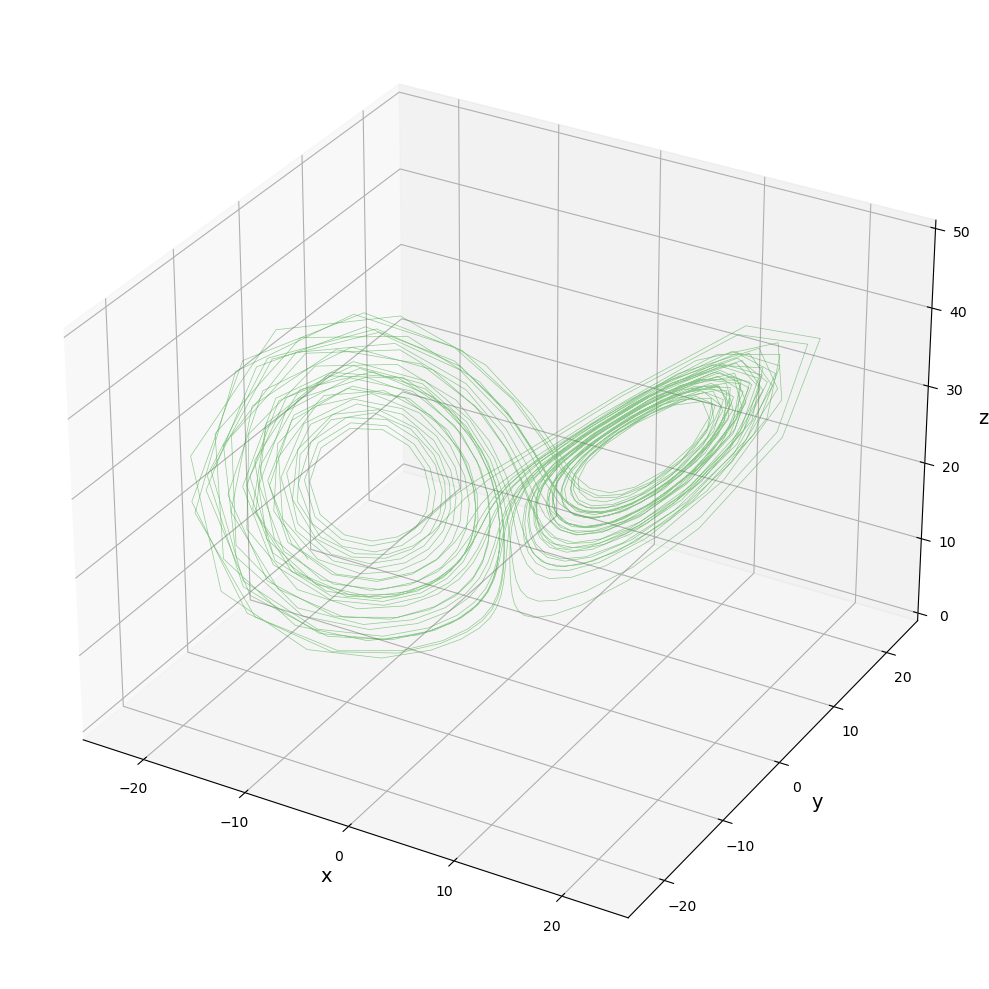

In [9]:
sigma = 10
rho = 28
beta = 8/3
X_init = np.array([1, 1, 1, sigma, rho, beta])

X_list = [X_init]

t_spinup = np.array(range(1000)) * 0.05

for ti in t_spinup:
    X_list.append(Model(X_list[-1], ti))

X_list = [X_list[-1]]

t_integration = np.array(range(1000, 2000)) * 0.05

for ti in t_integration:
    X_list.append(Model(X_list[-1], ti))

X_list.pop(0)
X_attractor= np.array(X_list)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

ax.plot(X_attractor[:, 0], X_attractor[:, 1], X_attractor[:, 2], lw=0.5, c="C2", alpha=0.5)
ax.set_xlabel("x", fontsize=lfontsize)
ax.set_ylabel("y", fontsize=lfontsize)
ax.set_zlabel("z", fontsize=lfontsize)
ax.set_xlim(-25, 25)
ax.set_ylim(-25, 25)
ax.set_zlim(0, 50)

plt.tight_layout()
plt.savefig("L63_attractor.png", dpi=300)
plt.show()

In [10]:
print(f"X_attractor.shape: {X_attractor.shape}")

X_attractor.shape: (1000, 6)


In [11]:
Y = X_attractor.copy()

for i in range(Y.shape[0]):
    Y[i, 0:3] += np.random.normal(0, 1, 3)

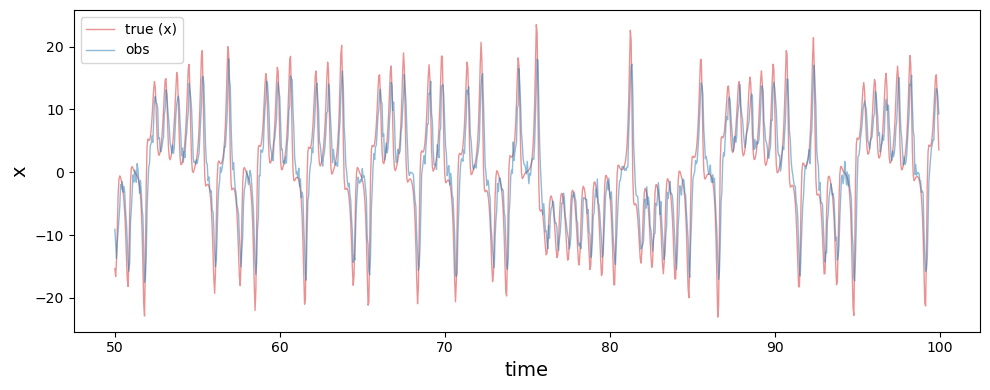

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))

ax.plot(t_integration, X_attractor[:, 1], lw=1.0, c="C3", alpha=0.5, label="true (x)")
ax.plot(t_integration, Y[:, 0],           lw=1.0, c="C0", alpha=0.5, label="obs")

ax.set_xlabel("time", fontsize=lfontsize)
ax.set_ylabel("x"   , fontsize=lfontsize)

ax.legend()
plt.tight_layout()
plt.savefig("L63_obs.png", dpi=300)
plt.show()

In [13]:
name_list = ["x", "y", "z", "sigma", "rho", "beta"]

def plot_result_xyz(idx, t_plot, t_integration, assim_X, assim_Pa, estim_Pf, Y, X_attractor):
    fig, ax = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

    obs_rmses, assim_rmses, trPa_xyz, trPf_xyz = [], [], [], []
    for i in range(len(t_integration)):
        obs_rmses  .append(np.sqrt(np.mean((Y[i, :]     [0:3] - X_attractor[i, :][0:3])**2)))
        assim_rmses.append(np.sqrt(np.mean((assim_X[i+1][0:3] - X_attractor[i, :][0:3])**2)))
        
        trPf_xyz.append(np.trace(estim_Pf[i+1][0:3, 0:3]))
    
    for i in range(len(t_plot)):
        trPa_xyz.append(np.trace(assim_Pa[i+1][0:3, 0:3]))
    
    ax[0].plot(t_integration, obs_rmses,   lw=0.5, c="C0", alpha=0.5, label="obs rmse XYZ")
    ax[0].plot(t_integration, assim_rmses, lw=1.0, c="C1", alpha=1.0, label="assim rmse XYZ")
    ax[0].plot(t_plot       , trPa_xyz,    lw=1.0, c="C2", alpha=0.5, label="trPa XYZ")
    ax[0].plot(t_integration, trPf_xyz,    lw=0.5, c="C3", alpha=0.5, label="trPf XYZ")
    ax[0].set_ylabel("RMSE (XYZ)", fontsize=lfontsize)
    ax[0].legend(loc="upper right")

    np_assim_X = np.array(assim_X)
    ax[1].plot(t_integration, Y[:, idx],          lw=0.5, c="C0", alpha=0.5, label="obs")
    ax[1].plot(t_integration, X_attractor[:, idx], lw=1.0, c="C2", alpha=1.0, label=f"true ({name_list[idx]})")
    ax[1].plot(t_integration, np_assim_X[1:, idx], lw=1.0, c="C1", alpha=1.0, label="assim")

    ax[1].set_xlabel("time"        , fontsize=lfontsize)
    ax[1].set_ylabel(name_list[idx], fontsize=lfontsize)
    ax[1].legend()

    plt.tight_layout()
        

In [14]:
def plot_result_srb(idx, t_plot, t_integration, assim_X, assim_Pa, estim_Pf, Y, X_attractor):
    fig, ax = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

    obs_rmses, assim_rmses, trPa_srb, trPf_srb = [], [], [], []
    for i in range(len(t_integration)):
        obs_rmses  .append(np.sqrt(np.mean((Y[i, :]     [3:6] - X_attractor[i, :][3:6])**2)))
        assim_rmses.append(np.sqrt(np.mean((assim_X[i+1][3:6] - X_attractor[i, :][3:6])**2)))
        
        trPf_srb.append(np.trace(estim_Pf[i+1][3:6, 3:6]))
    
    for i in range(len(t_plot)):
        trPa_srb.append(np.trace(assim_Pa[i+1][3:6, 3:6]))
    
    ax[0].plot(t_integration, obs_rmses,   lw=0.5, c="C0", alpha=0.5, label="obs rmse srb")
    ax[0].plot(t_integration, assim_rmses, lw=1.0, c="C1", alpha=1.0, label="assim rmse srb")
    ax[0].plot(t_plot       , trPa_srb,    lw=1.0, c="C2", alpha=0.5, label="trPa srb")
    ax[0].plot(t_integration, trPf_srb,    lw=0.5, c="C3", alpha=0.5, label="trPf srb")
    ax[0].set_ylabel("RMSE (srb)", fontsize=lfontsize)
    ax[0].legend(loc="upper right")

    np_assim_X = np.array(assim_X)
    ax[1].plot(t_integration, Y[:, idx],          lw=0.5, c="C0", alpha=0.5, label="obs")
    ax[1].plot(t_integration, X_attractor[:, idx], lw=1.0, c="C2", alpha=1.0, label=f"true ({name_list[idx]})")
    ax[1].plot(t_integration, np_assim_X[1:, idx], lw=1.0, c="C1", alpha=1.0, label="assim")

    ax[1].set_xlabel("time"        , fontsize=lfontsize)
    ax[1].set_ylabel(name_list[idx], fontsize=lfontsize)
    ax[1].legend()

    plt.tight_layout()
        

## RNN

```
# N: batch num
# T: window size (fixed to 1 in this experiment)
# Dx: Input size(feature num)
# Dh: Hidden size (fixed to J in this experiment)
# Dz: Output size (fixed to J)
```

RNNCell

$\vec{h}_t = \tanh(\mathrm{W}^{(in)} \vec{x} + \mathrm{W}^{(rec)} \vec{h}_{t-1} + \vec{b})$

```
    input:
        x: (1xDin)

        params:
        Win: (Dx x Dh)
        Wrec: (Dh x Dh)
        b: (1 x Dh)

        h_prev: (1 x Dh)
```

Affine (Dense)

$\vec{z} = \mathrm{W}^{(out)} \vec{h} + \vec{b}$

```
    input:
        h: 
```

In [21]:
def RNNCell_forward(x, Win, Wrec, b, h_prev):
    h = np.tanh(Win @ x + Wrec @ h_prev + b)
    return h

In [22]:
def RNN_forward(X, Win, Wrec, b, h0=None):
    N, T, J = X.shape
    H = Wrec.shape[0]

    h = np.zeros((T, H))
    if h0 is None:
        h0 = np.zeros(H)
    h[0, :] = h0
    for i in range(T):
        h[i, :] = RNNCell_forward(X[i, :], Win, Wrec, b, h[i-1, :])
    return h

In [23]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [25]:
def Affine_forward(h, Wout, b):
    z = sigmoid(Wout @ h + b)
    return z

In [26]:
def RNNmodel_forward(X, Win, Wrec, b, Wout, b_out, h0=None):
    h = RNN_forward(X, Win, Wrec, b, h0)
    z = Affine_forward(h, Wout, b_out)
    return z, h

In [27]:
n_hidden = 3
n_lag = 1

Dx = 3
T  = n_lag

Dh = n_hidden
Dz = Dx

def RNNmodel_forward_explicit(XX, t):
    X = XX[0:Dx * T].reshape((T, Dx))

    cursor_s, cursor_l = Dx * T, J * H
    Win = XX[cursor_s : cursor_s + cursor_l].reshape((Dh, Dx))

    cursor_s += cursor_l
    cursor_l = Dh * Dh
    Wrec = XX[cursor_s : cursor_s + cursor_l].reshape((Dh, Dh))

    cursor_s += cursor_l
    cursor_l = Dh
    b = XX[cursor_s : cursor_s + cursor_l].reshape((Dh,))

    cursor_s += cursor_l
    cursor_l = Dz * Dz
    Wout = XX[cursor_s : cursor_s + cursor_l].reshape((1, Dh))

In [ ]:
Y_input = 